Load the data and take a look.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
#import statsmodels
import matplotlib.pyplot as plt
import math

## Read in Data
obs = pd.read_csv("observations.csv")
species = pd.read_csv("species_info.csv")

In [2]:
print(f"species shape: {species.shape}")
print(species.head(10))

species shape: (5824, 4)
  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   
5   Mammal         Odocoileus virginianus   
6   Mammal                     Sus scrofa   
7   Mammal                  Canis latrans   
8   Mammal                    Canis lupus   
9   Mammal                    Canis rufus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  
5                            

### Species Distribution
Lets take a look at the counts for the scientific names column.

In [3]:
print(f"Number of species:{species.scientific_name.nunique()}")
print(f"Number of categories:{species.category.nunique()}")
print(f"Category types:{species.category.unique()}")

Number of species:5541
Number of categories:7
Category types:['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


Lets plot this out for a better visualisation of types of species.

category
Amphibian             80
Bird                 521
Fish                 127
Mammal               214
Nonvascular Plant    333
Name: common_names, dtype: int64


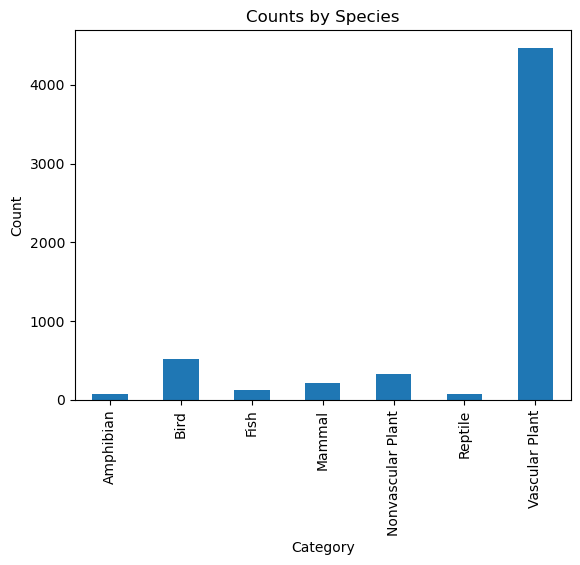

<Figure size 640x480 with 0 Axes>

In [4]:
categoryData = species.groupby('category')['common_names'].count()
print(categoryData.head())
ax = categoryData.plot(kind='bar')
ax.set_xlabel("Category")
ax.set_ylabel("Count")
plt.title("Counts by Species")
plt.show()
plt.clf()

Vascular Plants are by far the most common. The Most common animal type are Birds.
### Distribution of Conservation Status
Lets take a look at the conservation status data.

In [5]:
print(f"Number of conservation status types:{species.conservation_status.nunique()}")
print(f"Unique conservation status types:{species.conservation_status.unique()}")
conStat = species.groupby('conservation_status')['common_names'].count()
print(f'Conservation status count:\n {conStat}')
print(f"NaN count:{species.conservation_status.isna().sum()}")

Number of conservation status types:4
Unique conservation status types:[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']
Conservation status count:
 conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
Name: common_names, dtype: int64
NaN count:5633


The classifications are:
 Not Evaluated, Data Deficient, Least Concern, Near Threatened, Vulnerable, Endangered, Critically Endangered, Extinct in the Wild and Extinct.

Since there are quite a lot of missing data in the column (nan), we could either assume the first three categories. We could assume the NaN means they are common and therefore LC, but a few could be DD or even NE.
Lets clean up that data.

In [6]:
print(f"New NaN count:{species.conservation_status.isna().sum()}")
species.fillna('Least Concern', inplace=True)
species.groupby("conservation_status").size()

New NaN count:5633


conservation_status
Endangered              16
In Recovery              4
Least Concern         5633
Species of Concern     161
Threatened              10
dtype: int64

Lets get some counts of species conservation status:

In [7]:
consCat = species[species.conservation_status != 'Least Concern'].groupby(["conservation_status", "category"])['scientific_name']\
    .count().unstack()

print(consCat)

category             Amphibian  Bird  Fish  Mammal  Nonvascular Plant  \
conservation_status                                                     
Endangered                 1.0   4.0   3.0     7.0                NaN   
In Recovery                NaN   3.0   NaN     1.0                NaN   
Species of Concern         4.0  72.0   4.0    28.0                5.0   
Threatened                 2.0   NaN   4.0     2.0                NaN   

category             Reptile  Vascular Plant  
conservation_status                           
Endangered               NaN             1.0  
In Recovery              NaN             NaN  
Species of Concern       5.0            43.0  
Threatened               NaN             2.0  


Lets visualise the data:

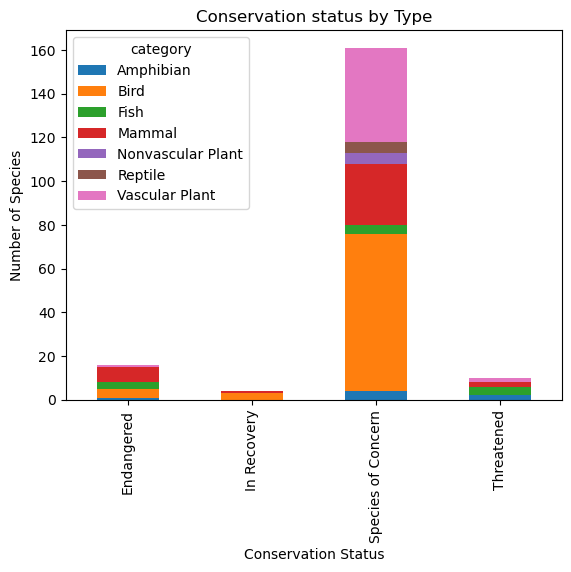

<Figure size 640x480 with 0 Axes>

In [8]:
ax = consCat.plot(kind = 'bar', stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species")
plt.title("Conservation status by Type")
plt.show()
plt.clf()

There are many species that are of concern in all categories. Birds appear to be the type that recovers quickest.
Fish appear to be most threatened.

#### Species vs Conservation Status

The next question asks if certain types of species are more likely to be endangered.
Lets create a new column with values other than `Least Concern`:

In [9]:
species['protected'] = species.conservation_status != 'Least Concern'

Create a group using `category` and the `protected` column, count the unique values and display.

In [10]:
import seaborn as sns
categoryCount = species.groupby(['category', 'protected']).scientific_name.nunique().reset_index()
categoryCount = categoryCount.pivot(columns='protected', index='category', values='scientific_name').reset_index()
categoryCount.columns = ['category', 'not_protected', 'protected']
categoryCount['percent_protected'] = (categoryCount.protected/(categoryCount.not_protected + categoryCount.protected) * 100).round(decimals=2)

print(categoryCount)


            category  not_protected  protected  percent_protected
0          Amphibian             72          7               8.86
1               Bird            413         75              15.37
2               Fish            115         11               8.73
3             Mammal            146         30              17.05
4  Nonvascular Plant            328          5               1.50
5            Reptile             73          5               6.41
6     Vascular Plant           4216         46               1.08


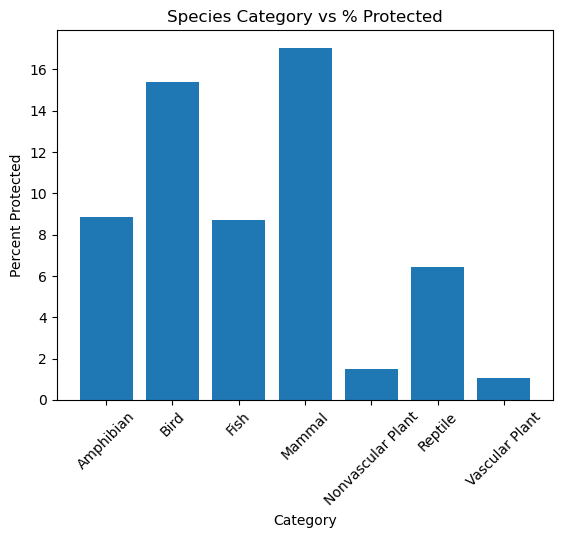

<Figure size 640x480 with 0 Axes>

In [11]:
plt.bar(data=categoryCount, x='category', height='percent_protected')
#ax = categoryCount.plot(kind = 'bar')
#ax.set_xlabel("Conservation Status", rotation=45)
#sns.barplot(data='categoryCount', x='category', y='percent_protected')
#plt.set_xlabel("Conservation Status")
plt.xticks(rotation=45)
plt.title("Species Category vs % Protected")
plt.ylabel("Percent Protected")
plt.xlabel("Category")
plt.show()
plt.clf()

By percentage of total species, Birds and mammals have the highest likelyhood of protected status.

## Which Species Were Spotted Most?
Lets take a look at the observation data:

In [12]:
print(obs.head(10))
print(f"observations shape: {obs.shape}")

                     scientific_name                            park_name  \
0                 Vicia benghalensis  Great Smoky Mountains National Park   
1                     Neovison vison  Great Smoky Mountains National Park   
2                  Prunus subcordata               Yosemite National Park   
3               Abutilon theophrasti                  Bryce National Park   
4           Githopsis specularioides  Great Smoky Mountains National Park   
5  Elymus virginicus var. virginicus               Yosemite National Park   
6                   Spizella pusilla            Yellowstone National Park   
7                  Elymus multisetus  Great Smoky Mountains National Park   
8             Lysimachia quadrifolia               Yosemite National Park   
9         Diphyscium cumberlandianum            Yellowstone National Park   

   observations  
0            68  
1            77  
2           138  
3            84  
4            85  
5           112  
6           228  
7       

In [32]:
# merge all the data
alldata = pd.merge(left=species, right=obs, left_on='scientific_name', right_on='scientific_name', how='outer')
print(alldata.head(10))


  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal  Clethrionomys gapperi gapperi   
2   Mammal  Clethrionomys gapperi gapperi   
3   Mammal  Clethrionomys gapperi gapperi   
4   Mammal                      Bos bison   
5   Mammal                      Bos bison   
6   Mammal                      Bos bison   
7   Mammal                      Bos bison   
8   Mammal                     Bos taurus   
9   Mammal                     Bos taurus   

                                        common_names conservation_status  \
0                           Gapper's Red-Backed Vole       Least Concern   
1                           Gapper's Red-Backed Vole       Least Concern   
2                           Gapper's Red-Backed Vole       Least Concern   
3                           Gapper's Red-Backed Vole       Least Concern   
4                              American Bison, Bison       Least Concern   
5                              American Bison, B

Check for null counts

In [34]:
print(alldata.info())
print("isna results:")
print(alldata.isna().value_counts())
print("isnull results:")
print(alldata.isnull().value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25632 entries, 0 to 25631
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             25632 non-null  object
 1   scientific_name      25632 non-null  object
 2   common_names         25632 non-null  object
 3   conservation_status  25632 non-null  object
 4   protected            25632 non-null  bool  
 5   park_name            25632 non-null  object
 6   observations         25632 non-null  int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 1.4+ MB
None
isna results:
category  scientific_name  common_names  conservation_status  protected  park_name  observations
False     False            False         False                False      False      False           25632
dtype: int64
isnull results:
category  scientific_name  common_names  conservation_status  protected  park_name  observations
False     False            False         Fal

Check for any duplicates

In [35]:
alldata.duplicated().value_counts()

False    25601
True        31
dtype: int64

Let's plot the data for some visuals! Observations by category:

            category  observations
0     Vascular Plant       2795312
1               Bird        332371
2  Nonvascular Plant        190653
3             Mammal        163120
4               Fish         72901
5            Reptile         45822
6          Amphibian         45068


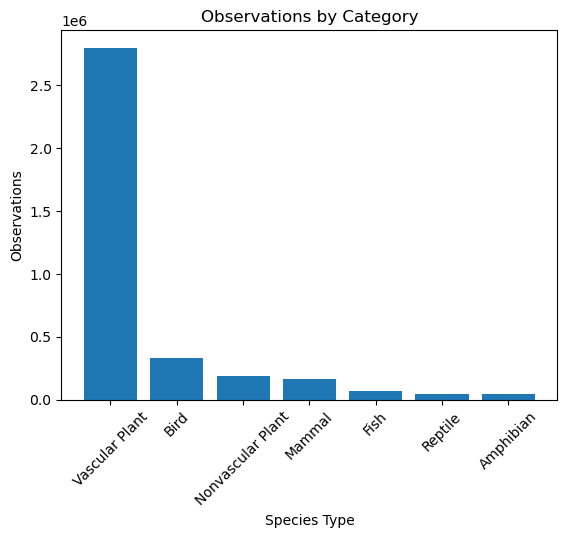

"categoryCount = species.groupby(['category', 'protected']).scientific_name.nunique().reset_index()\ncategoryCount = categoryCount.pivot(columns='protected', index='category', values='scientific_name').reset_index()\ncategoryCount.columns = ['category', 'not_protected', 'protected']\ncategoryCount['percent_protected'] = (categoryCount.protected/(categoryCount.not_protected + categoryCount.protected) * 100).round(decimals=2)"

In [56]:
counts = alldata[['category', 'observations']].groupby(['category']).observations.sum().sort_values(ascending=False).reset_index()
print(counts)
#print(counts)
plt.bar(data=counts, x='category', height='observations')
plt.xticks(rotation=45)
plt.title("Observations by Category")
plt.ylabel("Observations")
plt.xlabel("Species Type")
plt.show()
plt.clf


How many observations per park?

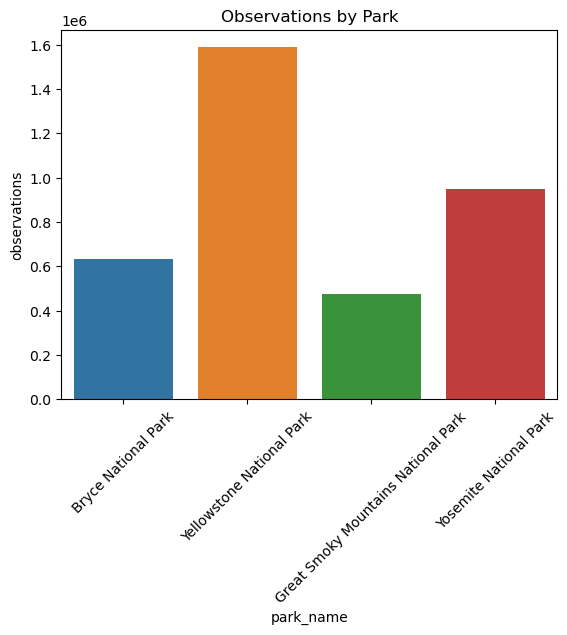

<function matplotlib.pyplot.clf()>

In [58]:
ax = sns.barplot(data=alldata, x='park_name', y='observations', estimator=sum, ci=None)
plt.title("Observations by Park")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()
plt.clf

Lets look at the breakdown by type at each park!
To do this we need to create another dataframe that includes all the needed data, park name, category, observations.

In [60]:
allObs = alldata[['park_name','category', 'observations']].groupby(['park_name','category']).observations.sum().unstack()
allObs = allObs.apply(lambda x: round(x/x.sum()*100,2), axis=1)
# View the Dataframe
allObs

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
park_name,,,,,,,
Bryce National Park,1.19,9.25,2.02,4.55,5.21,1.29,76.49
Great Smoky Mountains National Park,1.24,9.03,2.00,4.43,5.23,1.23,76.84
Yellowstone National Park,1.26,9.09,1.98,4.45,5.23,1.26,76.73
Yosemite National Park,1.23,9.12,2.02,4.48,5.24,1.24,76.66


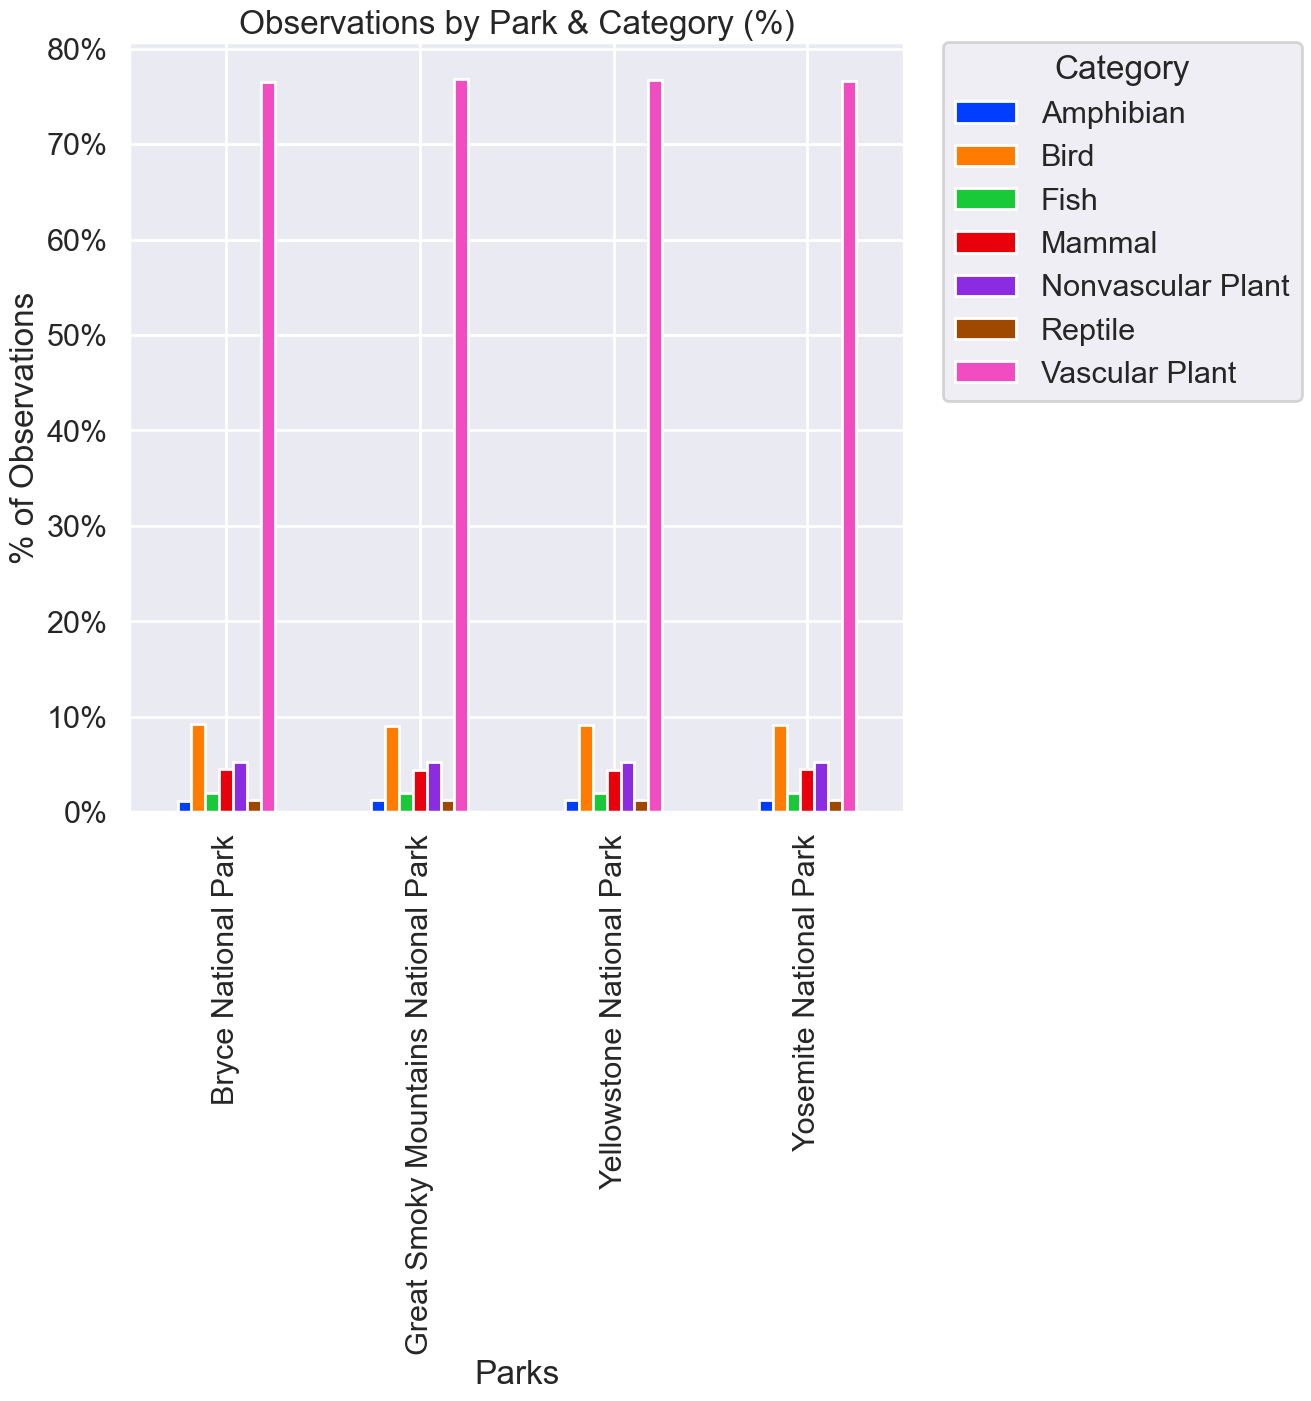

In [74]:
sns.set_context('poster')
sns.set_style("darkgrid")
sns.set_palette("bright")
ax = allObs.plot(kind='bar', figsize=(10, 10))
plt.title('Observations by Park & Category (%)')
plt.xlabel('Parks')
plt.ylabel('% of Observations')
ax.yaxis.set_major_formatter(lambda x,pos :'{:.0f}%'.format(x))
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Are the differences between species and their conservation status significant?
Lets do some chi-squared tests to see if different kinds of species have statistically significant differences in conservation status rates. 
We will need to create a contingency table for this.

In [77]:
from scipy.stats import chi2_contingency

significance_threshold = 0.05

contingency = pd.crosstab(species.protected, species.category)
print(contingency)

chi2, pval, dof, expected = chi2_contingency(contingency, correction=False)

# determine significance:
result = ('significant' if pval < significance_threshold else 'not significant')
print(f'There is {result} result with pval being {pval}')


category   Amphibian  Bird  Fish  Mammal  Nonvascular Plant  Reptile  \
protected                                                              
False             73   442   116     176                328       74   
True               7    79    11      38                  5        5   

category   Vascular Plant  
protected                  
False                4424  
True                   46  
There is significant result with pval being 3.095911909904608e-98


Some are likely to be protected than others.